# Kinematic coverage

In [1]:
%reset -f

import ROOT

ROOT.gStyle.SetOptFit(1)
ROOT.gStyle.SetOptStat(0)
ROOT.gStyle.SetGridColor(16)
ROOT.gStyle.SetPadGridX(1)
ROOT.gStyle.SetPadGridY(1)
ROOT.gStyle.SetPadRightMargin(0)
ROOT.gStyle.SetPadBottomMargin(0.13)
ROOT.gStyle.SetPadLeftMargin(0.07)
ROOT.gStyle.SetTitleOffset(0.7, 'Y')
ROOT.gStyle.SetTitleSize(0.09,'T')
ROOT.gStyle.SetTitleSize(0.065,'xy')
ROOT.gStyle.SetLabelSize(0.055,'xy')

ROOT.TH1.AddDirectory(0)

%run -i eppi0_columns.py
%run -i eppi0_binning_scheme_v3.py

rdfs = []
for fname in ['data/lvl2_eppi0.inb.qa.ecorr.root','data/lvl2_eppi0.inb.mc.smear.root','data/lvl2_eppi0.outb.qa.ecorr.root','data/lvl2_eppi0.outb.mc.smear.root']:
    df = ROOT.RDataFrame("h22", fname)
    df = define_eppi0_columns_using_proton(df)
    if 'mc' in fname:
        df = df.Define("ihel","1")
    df = define_eppi0_bins(df, fname)
    df = process_eppi0_bins(df, fname)
    #df = df.Filter("abs(dpx)<0.3 && abs(dpy)<0.3 && abs(dphi)<4 && dpz>-0.5 && dpz<0.9")
    df = df.Filter("abs(dpt)<0.3 && abs(dphi)<4 && dpz>-0.5 && dpz<0.9 && mm2>-0.3 && mm2<0.4")
    df = df.Filter("&&".join(f"(((int)status)&(1<<{i}))" for i in [ecloose,gloosest,prodc]))
    df = df.Filter("thp<44.106+-6.625*pp+1.438*pp*pp")
    
    df = df.Define("pg", "array<double,2>{pg1,pg2}")
    df = df.Define("thg", "array<double,2>{thg1,thg2}")
    df = df.Define("fig", "array<double,2>{fig1,fig2}")

    rdfs.append(df)

Welcome to JupyROOT 6.26/00


In [2]:
hqs = [df.Histo1D(("hQ2","Q^{2};Q^{2} [GeV^{2}]",100,0,10), "q2") for df in rdfs]
hxs = [df.Histo1D(("hxB","x_{B};x_{B}",100,0,0.8), "xb") for df in rdfs]
hts = [df.Histo1D(("hmt","-t;-t [GeV^{2}]",100,0,2), "tt") for df in rdfs]
hfis = [df.Histo1D(("hphistar","#phi^{*};#phi^{*} [#circ]",100,0,360),"phistar") for df in rdfs]

hmm2s = [df.Histo1D(("hmm2","MM^{2}_{epX};MM^{2} [GeV^{2}]",200,-1,1.5), "mm2") for df in rdfs]
hmggs = [df.Filter("mm2>-0.3 && mm2<0.4").Histo1D(("hmgg","M_{#gamma#gamma};M_{#gamma#gamma} [GeV]",200,0,0.25), "mgg") for df in rdfs]



hpes = [df.Histo1D(("hpe","P_{e};P_{e} [GeV]",100,0,10), "pe") for df in rdfs]
hthes = [df.Histo1D(("hthe","#theta_{e};#theta_{e} [#circ]",100,0,40), "the") for df in rdfs]
hfies = [df.Histo1D(("hfie","#phi_{e};#phi_{e} [#circ]",100,0,360), "fie") for df in rdfs]

hpps = [df.Histo1D(("hpp","P_{p};P_{p} [GeV]",100,0,5), "pp") for df in rdfs]
hthps = [df.Histo1D(("hthp","#theta_{p};#theta_{p} [#circ]",100,0,50), "thp") for df in rdfs]
hfips = [df.Histo1D(("hfip","#phi_{p};#phi_{p} [#circ]",100,0,360), "fip") for df in rdfs]

hpgs = [df.Histo1D(("hpg","P_{#gamma};P_{#gamma} [GeV]",100,0,10), "pg") for df in rdfs]
hthgs = [df.Histo1D(("hthg","#theta_{#gamma};#theta_{#gamma} [#circ]",100,0,40), "thg") for df in rdfs]
hfigs = [df.Histo1D(("hfig","#phi_{#gamma};#phi_{#gamma} [#circ]",100,0,360), "fig") for df in rdfs]


hpthp = [df.Histo2D(("hpthp","#theta_{p} vs p_{p};p_{p} [GeV];#theta_{p} [#circ]",100,0,5, 100,0,50), "pp","thp") for df in rdfs]
hpthg = [df.Histo2D(("hgthp","#theta_{#gamma} vs p_{#gamma};p_{#gamma} [GeV];#theta_{#gamma} [#circ]",100,0,10, 100,0,50), "pg","thg") for df in rdfs]
gdf = df.Filter("&&".join(f"!(((int)status)&(1<<{i}))" for i in [gloose]))
hpthg1 = [gdf.Histo2D(("hgthp","#theta_{#gamma} vs p_{#gamma};p_{#gamma} [GeV];#theta_{#gamma} [#circ]",100,0,10, 100,0,50), "pg","thg") for df in rdfs]




### Kinematic variables

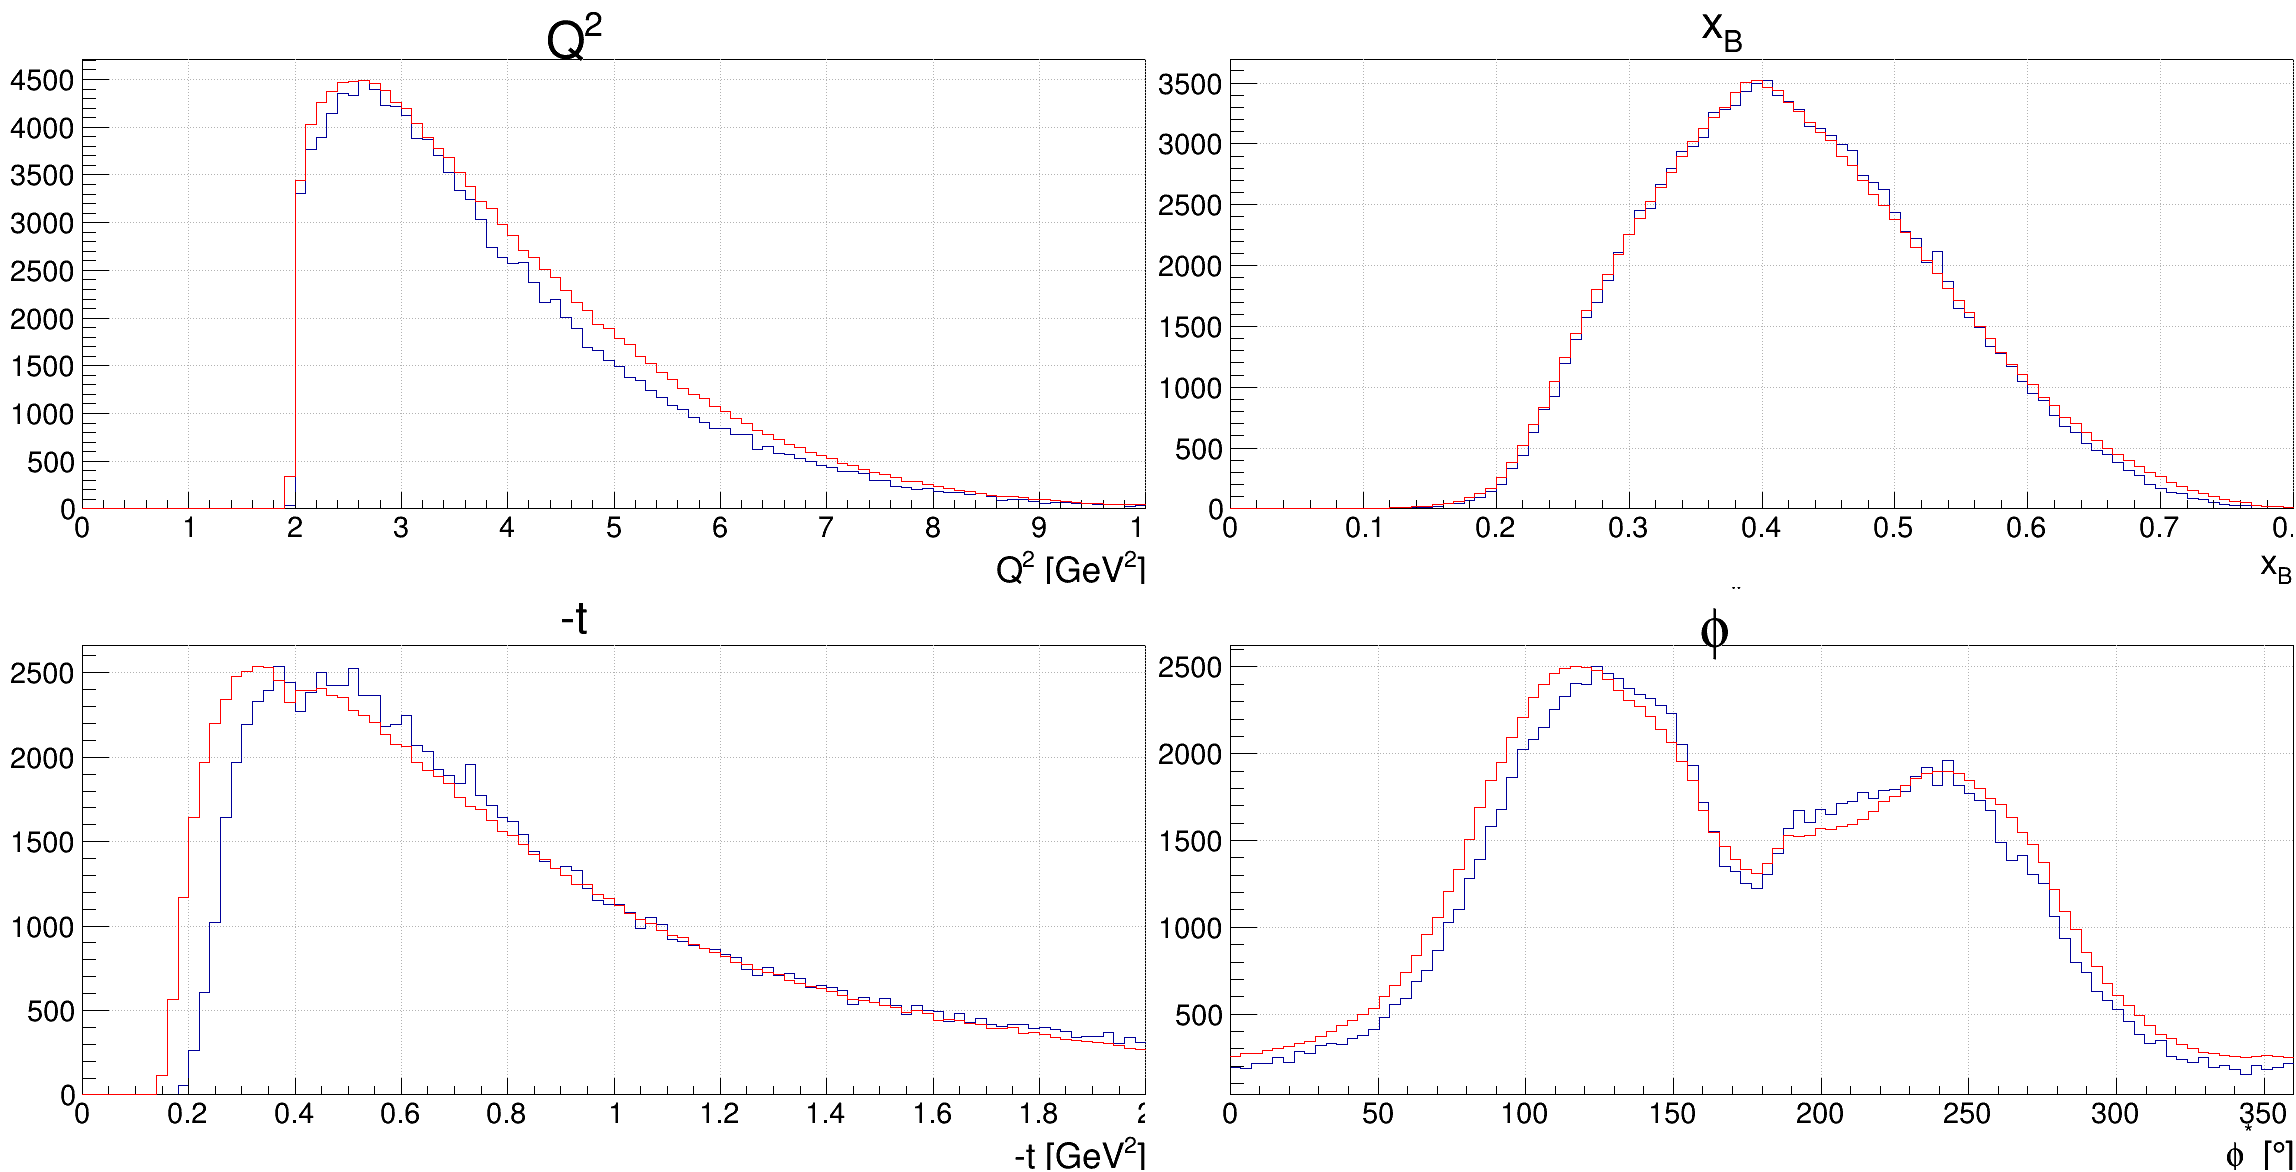

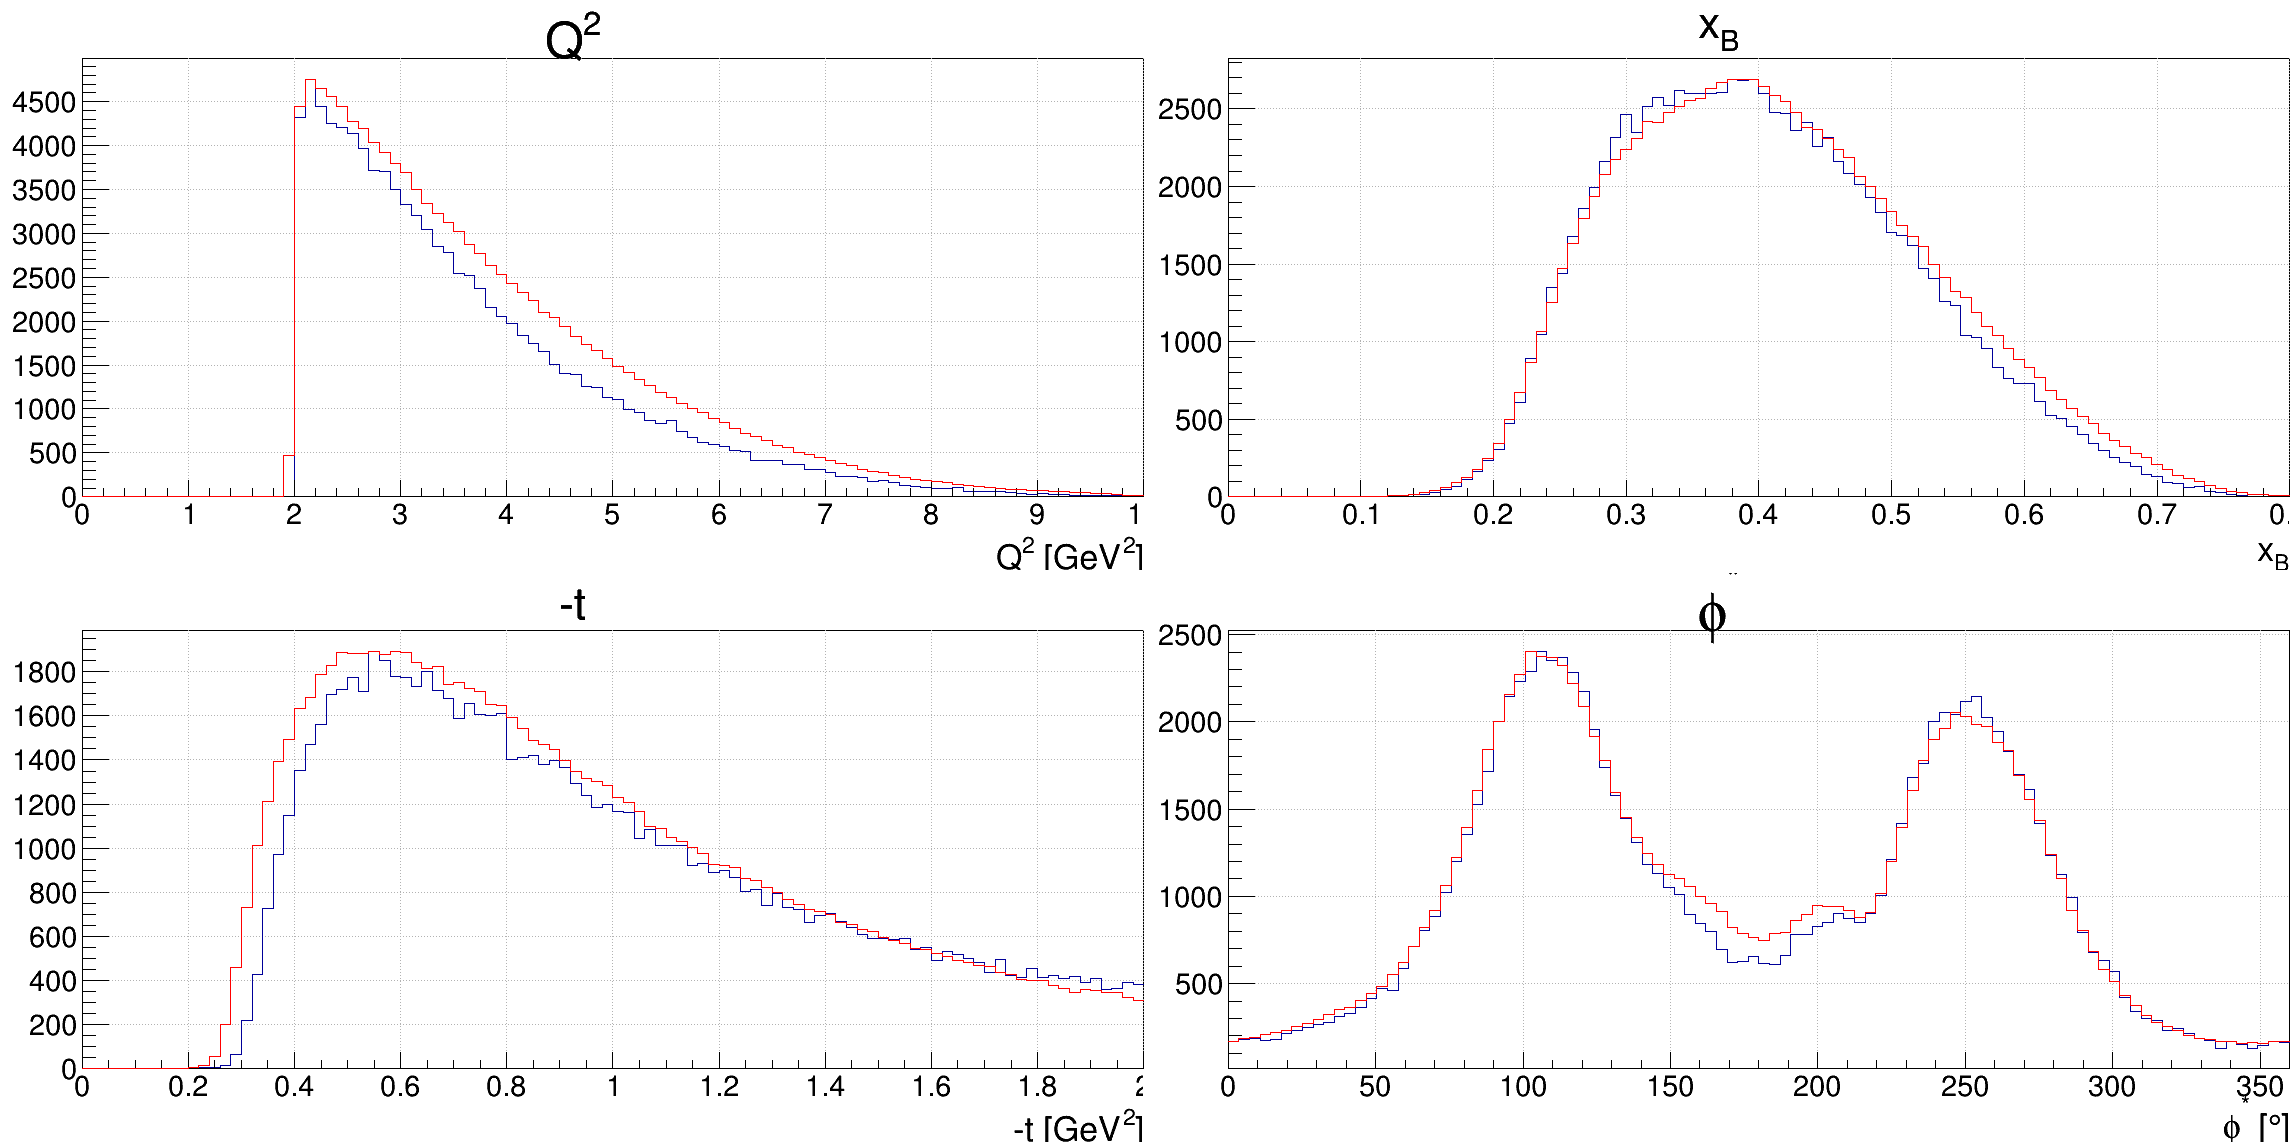

In [3]:
c1 = ROOT.TCanvas("c0","c0",2300,1200)
c1.SetTopMargin(0)
c1.SetRightMargin(0)
c1.Divide(2,2,0.001,0.001)
c1.Draw()

ipad = 0
for h1,h2 in [hqs[:2],hxs[:2],hts[:2],hfis[:2]]:
    ipad+=1
    c1.cd(ipad)
    h1.Draw()
    h2 = h1.mc = h2.Clone()
    scale = h2.GetMaximum()/h1.GetMaximum()
    h2.Scale(1/scale)
    h2.Draw("same hist")
    h2.SetLineColor(2)

c1.Print("pdf/MC_comparison.kinematics.inb.pdf")

#_____________________________________________________________________________________

c2 = c1.DrawClone()

ipad = 0
for h1,h2 in [hqs[2:],hxs[2:],hts[2:],hfis[2:]]:
    ipad+=1
    c2.cd(ipad)
    h1.Draw()
    h2 = h1.mc = h2.Clone()
    scale = h2.GetMaximum()/h1.GetMaximum()
    h2.Scale(1/scale)
    h2.Draw("same hist")
    h2.SetLineColor(2)

c1.Print("pdf/MC_comparison.kinematics.outb.pdf")

### Electrons

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


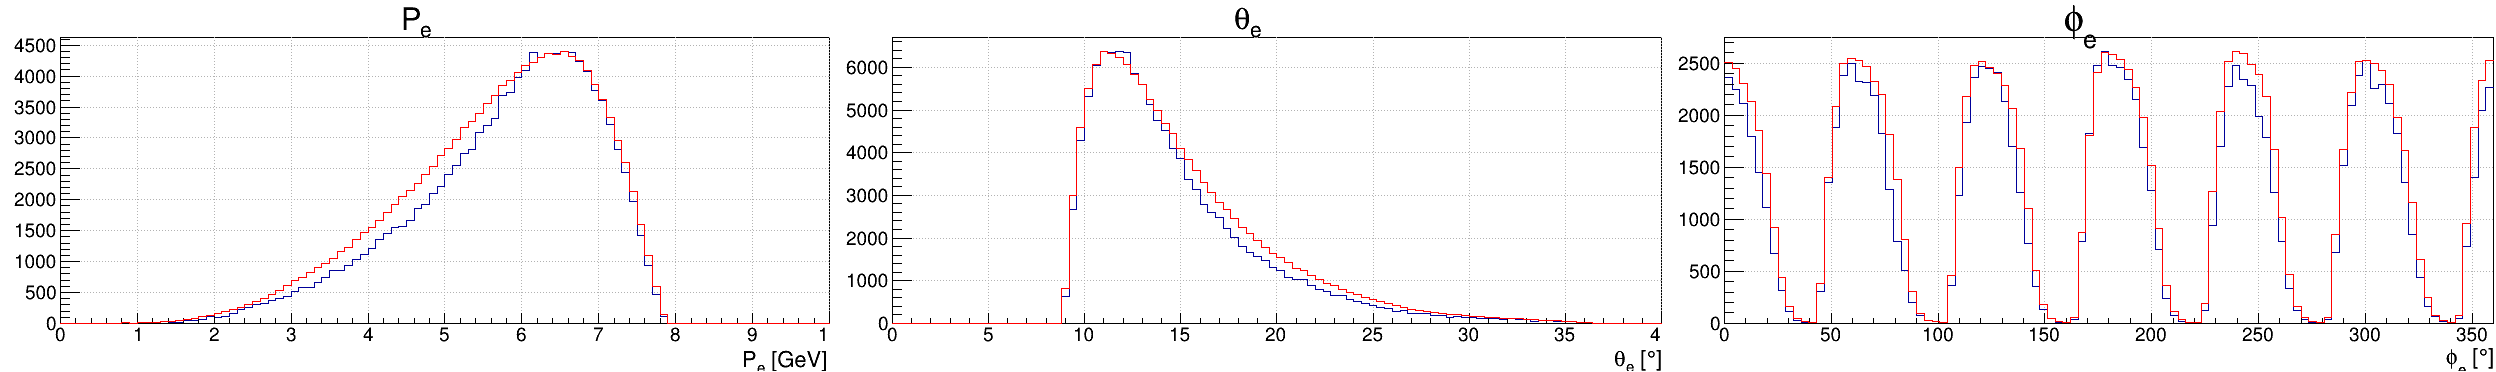

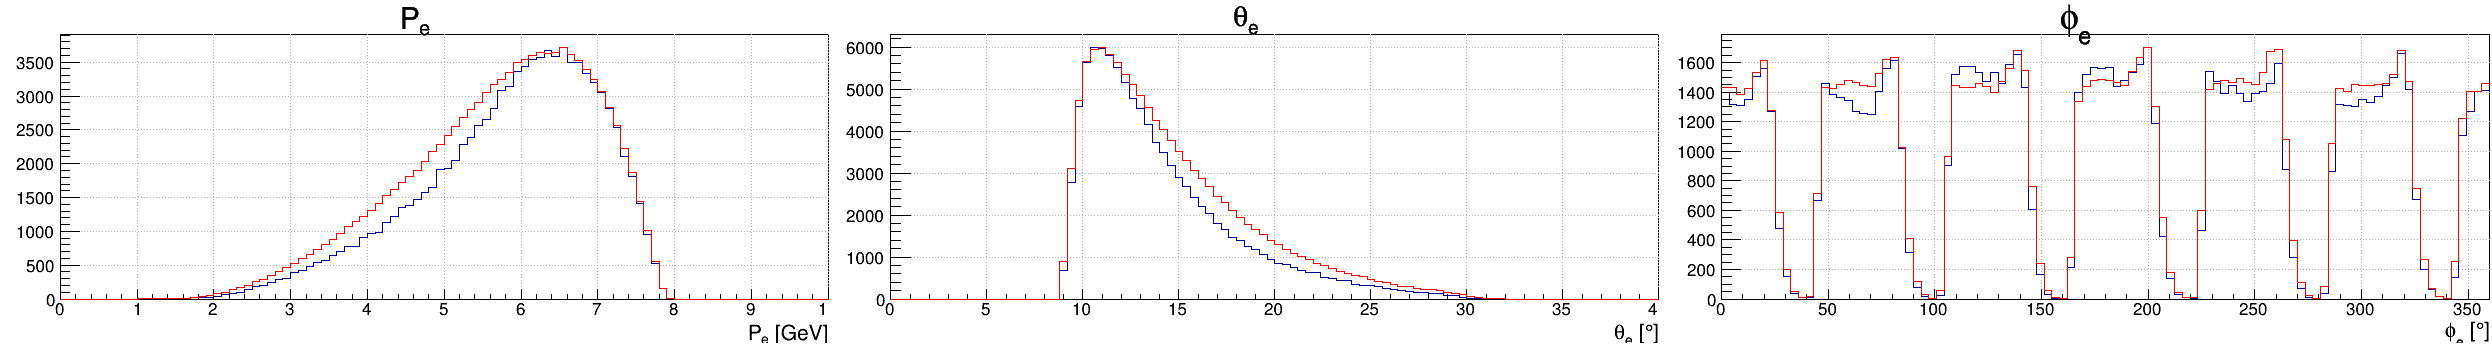

In [4]:
c1 = ROOT.TCanvas("c1","c1",2500,400)
c1.SetTopMargin(0)
c1.SetRightMargin(0)
c1.Divide(3,1,0.001,0.001)

c1.Draw()

ipad = 0
for h1,h2 in [hpes[:2],hthes[:2],hfies[:2]]:
    ipad+=1
    c1.cd(ipad)
    h1.Draw()
    h2 = h1.mc = h2.Clone()
    scale = h2.GetMaximum()/h1.GetMaximum()
    h2.Scale(1/scale)
    h2.Draw("same hist")
    h2.SetLineColor(2)

c1.Print("pdf/MC_comparison.electrons.inb.pdf")

#_____________________________________________________________________________________

c2 = c1.DrawClone()

ipad = 0
for h1,h2 in [hpes[2:],hthes[2:],hfies[2:]]:
    ipad+=1
    c2.cd(ipad)
    h1.Draw()
    h2 = h1.mc = h2.Clone()
    scale = h2.GetMaximum()/h1.GetMaximum()
    h2.Scale(1/scale)
    h2.Draw("same hist")
    h2.SetLineColor(2)

c1.Print("pdf/MC_comparison.electrons.outb.pdf")

### Protons

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


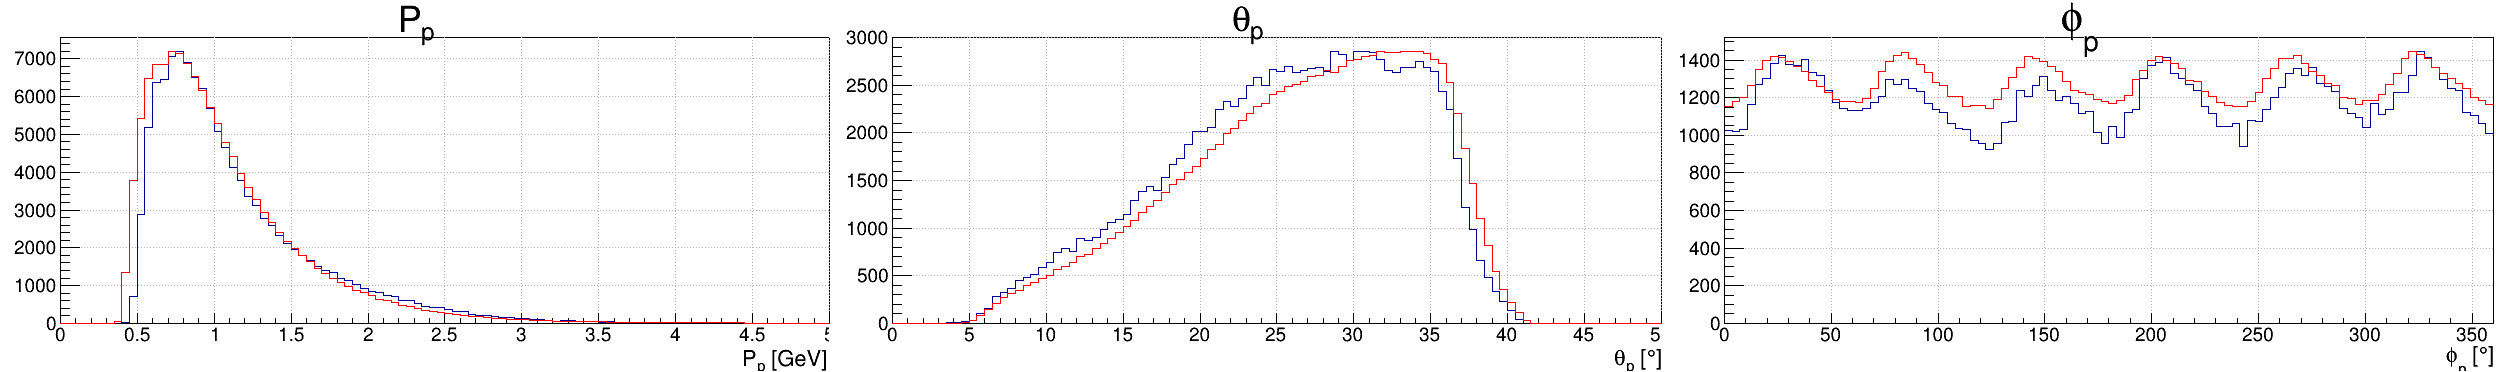

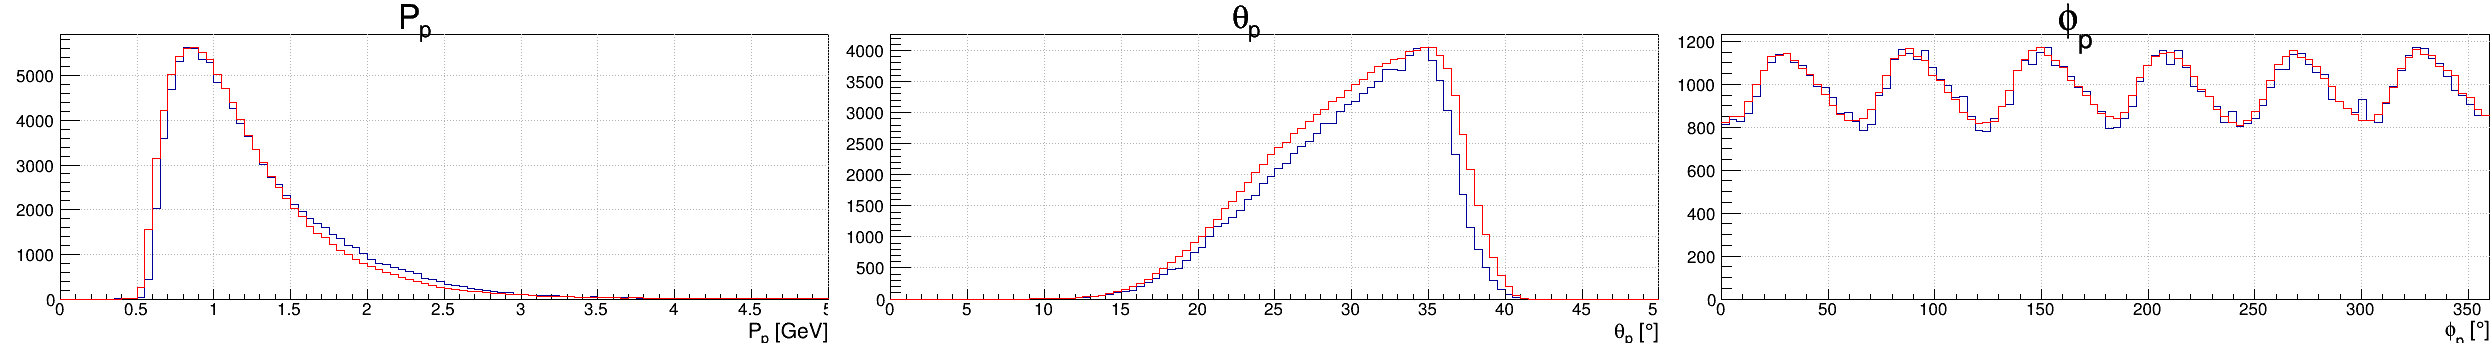

In [5]:
c1 = ROOT.TCanvas("c1","c1",2500,400)
c1.SetTopMargin(0)
c1.SetRightMargin(0)
c1.Divide(3,1,0.001,0.001)

c1.Draw()

ipad = 0
for h1,h2 in [hpps[:2],hthps[:2],hfips[:2]]:
    ipad+=1
    c1.cd(ipad)
    h1.SetMinimum(0)
    h1.Draw()
    h2 = h1.mc = h2.Clone()
    scale = h2.GetMaximum()/h1.GetMaximum()
    h2.Scale(1/scale)
    h2.Draw("same hist")
    h2.SetLineColor(2)

c1.Print("pdf/MC_comparison.protons.inb.pdf")

#_____________________________________________________________________________________

c2 = c1.DrawClone()

ipad = 0
for h1,h2 in [hpps[2:],hthps[2:],hfips[2:]]:
    ipad+=1
    c2.cd(ipad)
    h1.Draw()
    h1.SetMinimum(0)
    h2 = h1.mc = h2.Clone()
    scale = h2.GetMaximum()/h1.GetMaximum()
    h2.Scale(1/scale)
    h2.Draw("same hist")
    h2.SetLineColor(2)

c1.Print("pdf/MC_comparison.protons.outb.pdf")


### Photons

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


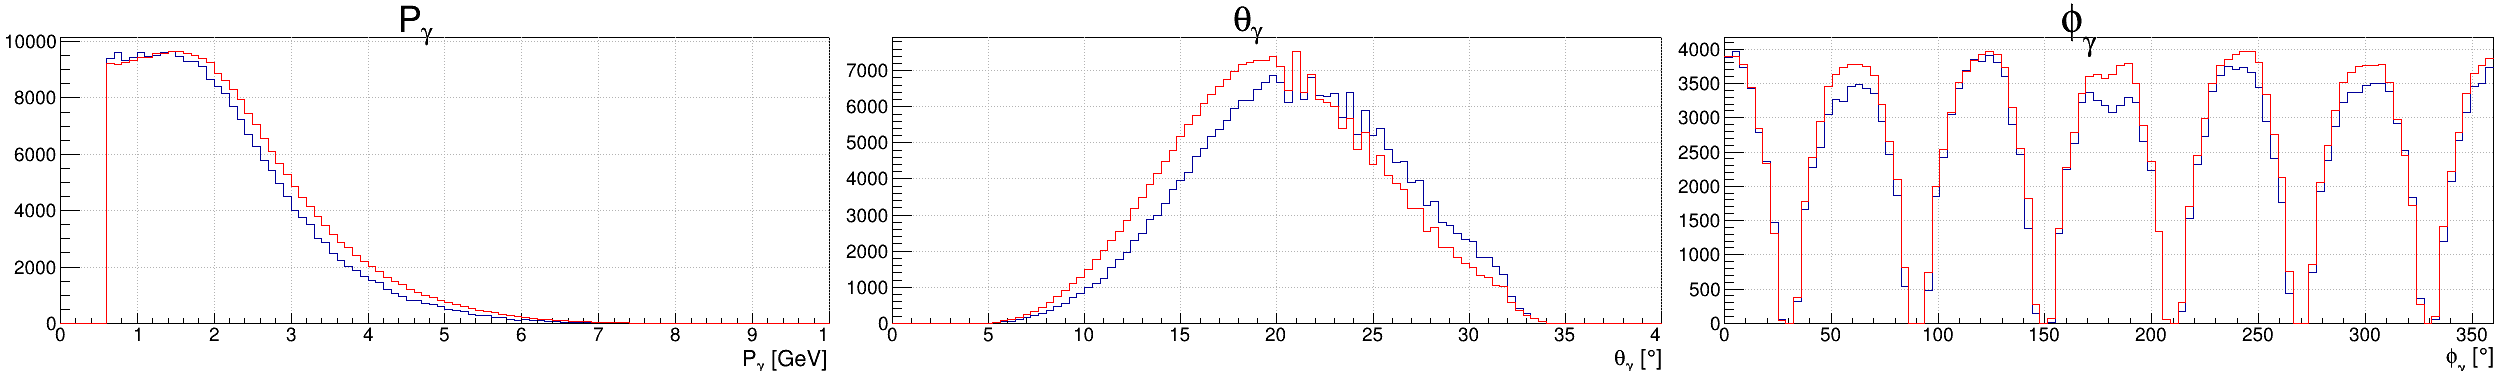

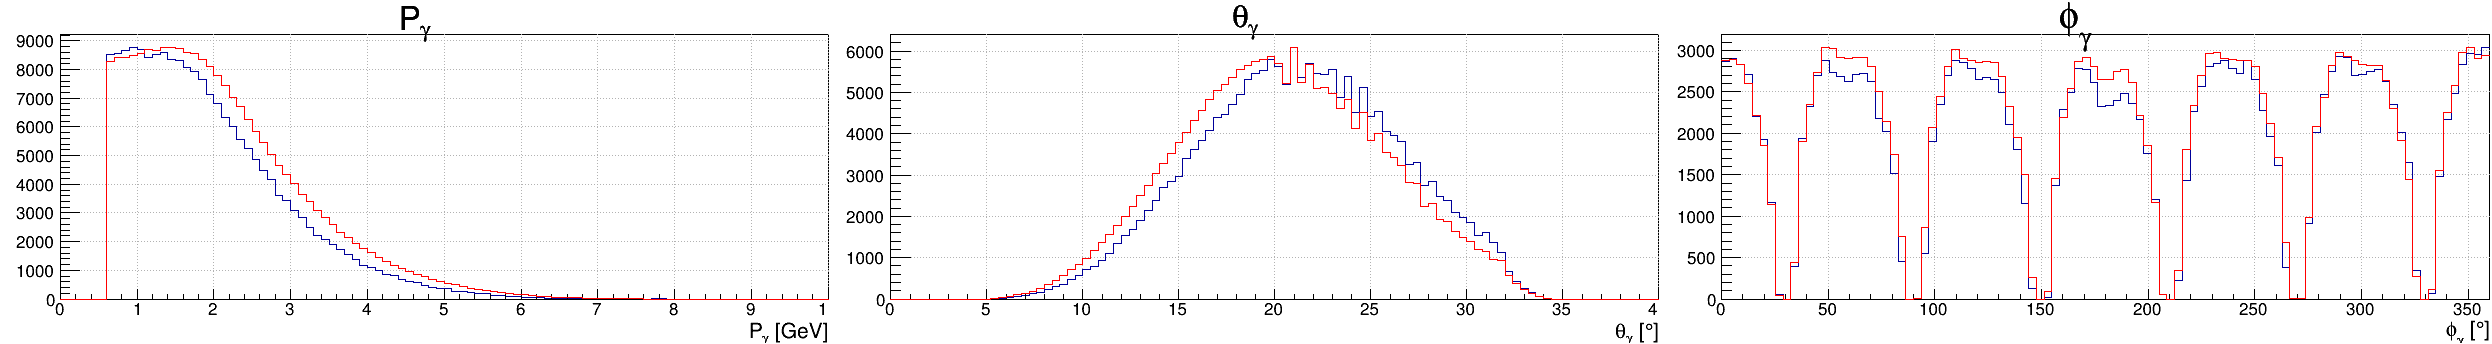

In [6]:
c1 = ROOT.TCanvas("c1","c1",2500,400)
c1.SetTopMargin(0)
c1.SetRightMargin(0)
c1.Divide(3,1,0.001,0.001)

c1.Draw()

ipad = 0
for h1,h2 in [hpgs[:2],hthgs[:2],hfigs[:2]]:
    ipad+=1
    c1.cd(ipad)
    h1.Draw()
    h2 = h1.mc = h2.Clone()
    scale = h2.GetMaximum()/h1.GetMaximum()
    h2.Scale(1/scale)
    h2.Draw("same hist")
    h2.SetLineColor(2)

c1.Print("pdf/MC_comparison.photons.inb.pdf")

#_____________________________________________________________________________________

c2 = c1.DrawClone()

ipad = 0
for h1,h2 in [hpgs[2:],hthgs[2:],hfigs[2:]]:
    ipad+=1
    c2.cd(ipad)
    h1.Draw()
    h2 = h1.mc = h2.Clone()
    scale = h2.GetMaximum()/h1.GetMaximum()
    h2.Scale(1/scale)
    h2.Draw("same hist")
    h2.SetLineColor(2)

c1.Print("pdf/MC_comparison.photons.outb.pdf")


### Proton angular/momentum coverage

In [7]:
gr = ROOT.TGraph()

#for x,y in [(0.65, 41), (1.05,39), (1.55,38), (2.05,37)]:
for x,y in [(0.65, 40.5), (1.05,38.5), (1.55,37.5), (2.05,36.5)]:
    gr.SetPoint(gr.GetN(), x,y)
f2 = ROOT.TF1("fpol2","pol2",0,5)
gr.Fit(f2,"QR")
gr
p0,p1,p2 = [f2.GetParameter(i) for i in range(3)]
print(f"{round(p0,3)}+{round(p1,3)}*pp+{round(p2,3)}*pp*pp")

44.106+-6.625*pp+1.438*pp*pp


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c1


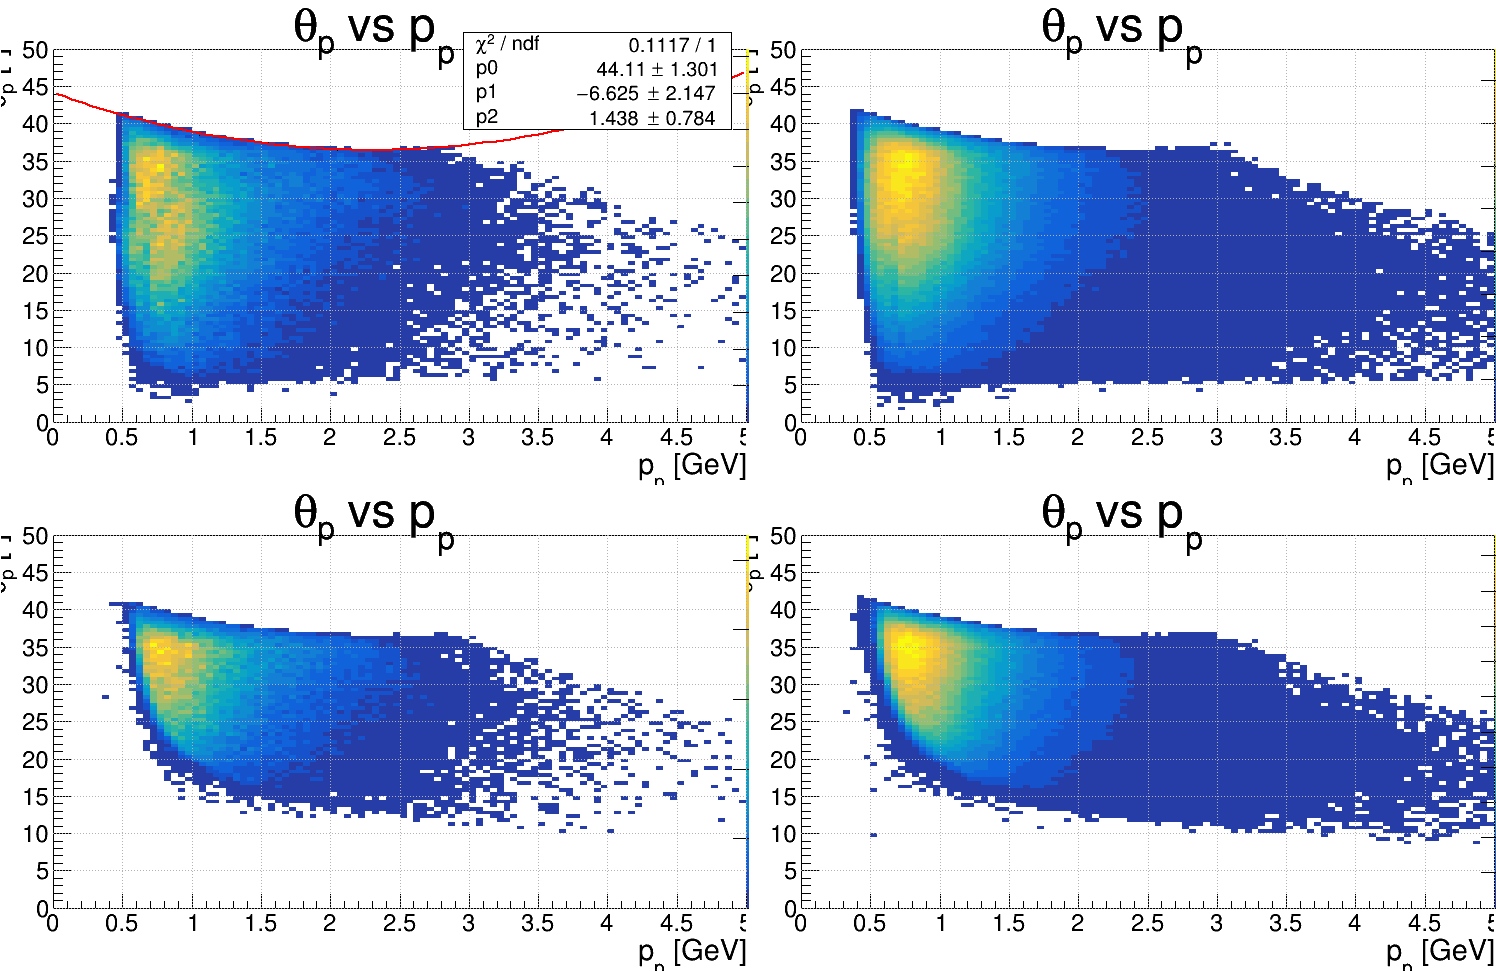

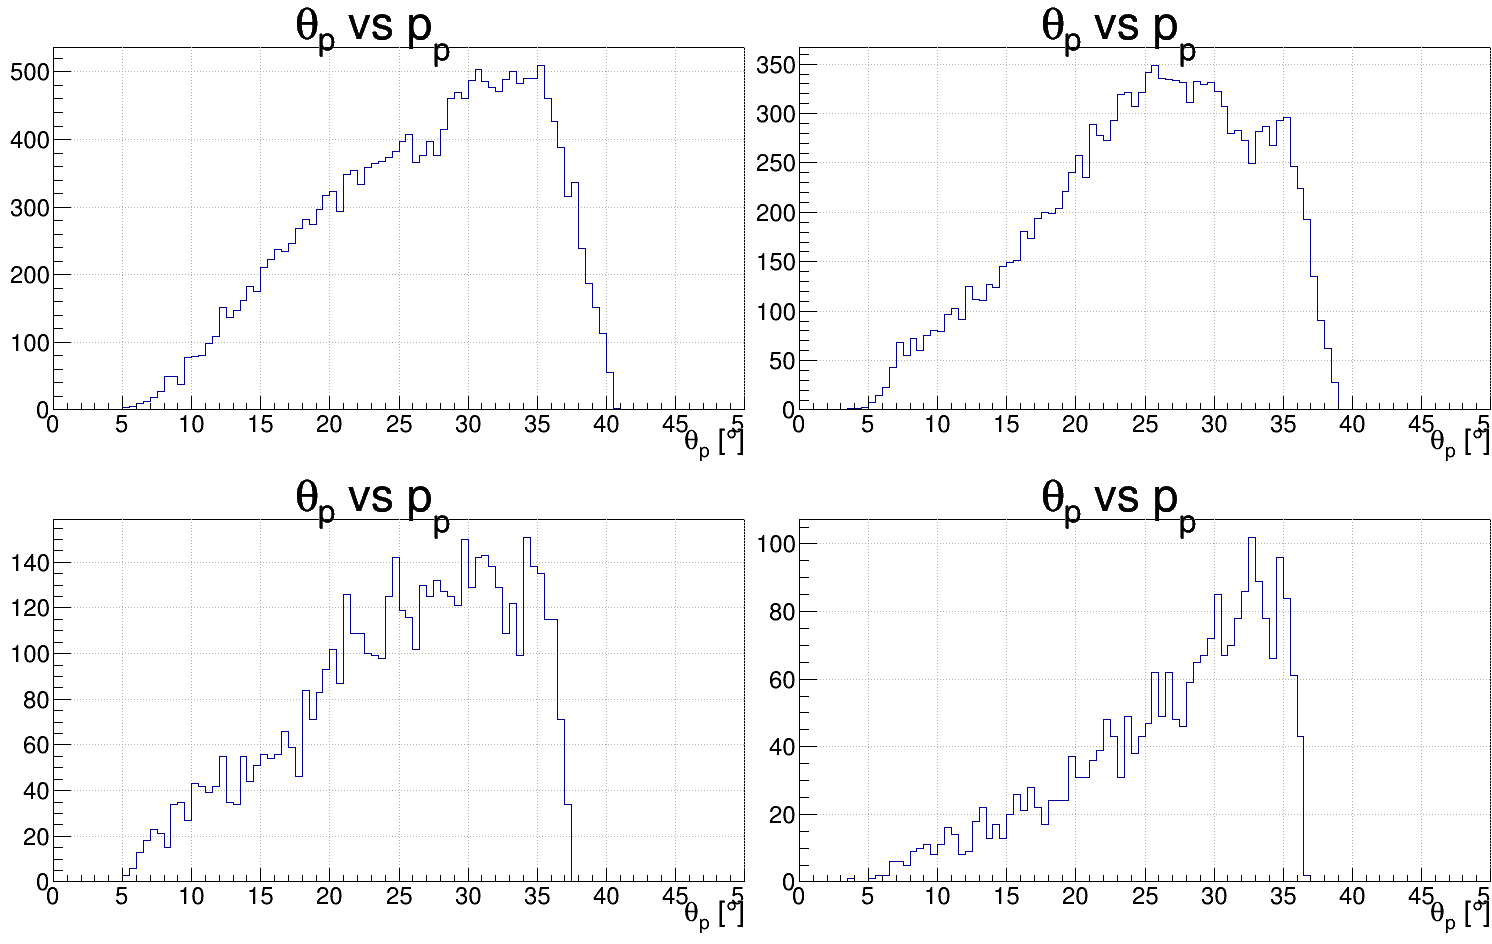

In [8]:
c1 = ROOT.TCanvas("c1","c1",1500,1000)
c1.SetTopMargin(0)
c1.SetRightMargin(0)
c1.Divide(2,2,0.001,0.001)

c1.Draw()
c2 = c1.DrawClone()

h1,h2,h3,h4 = hpthp

c1.cd(1)
h1.Draw("colz")
gr.Draw("same P")
c1.cd(2)
h2.Draw("colz")
c1.cd(3)
h3.Draw("colz")
c1.cd(4)
h4.Draw("colz")

hpp = h1.GetXaxis()
c2.cd(1)
hy1 = h1.ProjectionY("hy1",hpp.FindBin(0.6), hpp.FindBin(0.7))
hy1.Draw()
c2.cd(2)
hy2 = h1.ProjectionY("hy2",hpp.FindBin(1), hpp.FindBin(1.1))
hy2.Draw()
c2.cd(3)
hy3 = h1.ProjectionY("hy3",hpp.FindBin(1.5), hpp.FindBin(1.6))
hy3.Draw()
c2.cd(4)
hy4 = h1.ProjectionY("hy4",hpp.FindBin(2), hpp.FindBin(2.1))
hy4.Draw()

____________________________________
____________________________________
____________________________________